In [60]:
import os
import random
import yaml

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax.linen as nn
import tikzplotlib

from priorCVAE.datasets import SDEDataset
from priorCVAE.priors import DoubleWellSDE
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params, generate_decoder_samples
from matplotlib.image import imread

import jax.config as config
config.update("jax_enable_x64", True)


In [61]:
def bitmappify(ax, dpi=None):
    """
    Convert vector axes content to raster (bitmap) images
    """
    fig = ax.figure
    # safe plot without axes
    ax.set_axis_off()
    fig.savefig('temp.png', dpi=dpi, transparent=False)
    ax.set_axis_on()

    # remember geometry
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    xb = ax.bbox._bbox.corners()[:,0]
    xb = (min(xb), max(xb))
    yb = ax.bbox._bbox.corners()[:,1]
    yb = (min(yb), max(yb))

    # compute coordinates to place bitmap image later
    xb = (- xb[0] / (xb[1] - xb[0]),
        (1 - xb[0]) / (xb[1] - xb[0]))
    xb = (xb[0] * (xl[1] - xl[0]) + xl[0],
        xb[1] * (xl[1] - xl[0]) + xl[0])
    yb = (- yb[0] / (yb[1] - yb[0]),
        (1 - yb[0]) / (yb[1] - yb[0]))
    yb = (yb[0] * (yl[1] - yl[0]) + yl[0],
        yb[1] * (yl[1] - yl[0]) + yl[0])

    # replace the dots by the bitmap
    del ax.collections[:]
    del ax.lines[:]
    ax.imshow(imread('temp.png'), origin='upper', aspect='auto', extent=(xb[0], xb[1], yb[0], yb[1]),
              label='_nolegend_')

    # reset view
    ax.set_xlim(xl)
    ax.set_ylim(yl)

In [45]:
model_dir = "../../outputs/2023-10-21/22-50-08/"
output_dir = r"../../../../../papers/priorcvae/figures/DP/"
n = 5000 

In [24]:
cfg_path = os.path.join(model_dir, ".hydra", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

latent_dim = cfg_data["latent_dim"]
conditional = cfg_data["conditional"]
dec_activation_fn = cfg_data["dec_activation"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

x0 = cfg_data["x0"]
x1 = cfg_data["x1"]
n_data = cfg_data["n_data"]

In [25]:
x = jnp.linspace(x0, x1, n_data)

In [26]:
trained_decoder_params = load_model_params(os.path.join(model_dir, "model"))["decoder"]

In [27]:
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
# hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=[1000, 500, 100], out_dim=output_dim, activations=dec_activation_fn)

In [28]:
base_sde = DoubleWellSDE(q=3)
sde_datagenerator = SDEDataset(base_sde=base_sde, t=x[None, ...], 
                               x_init=jnp.array([1], dtype=x.dtype).reshape((1, 1)))


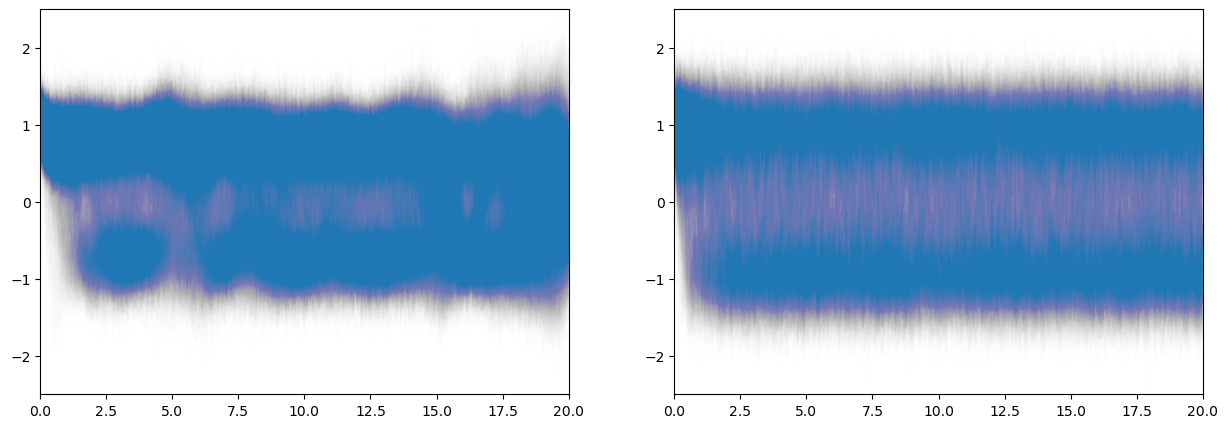

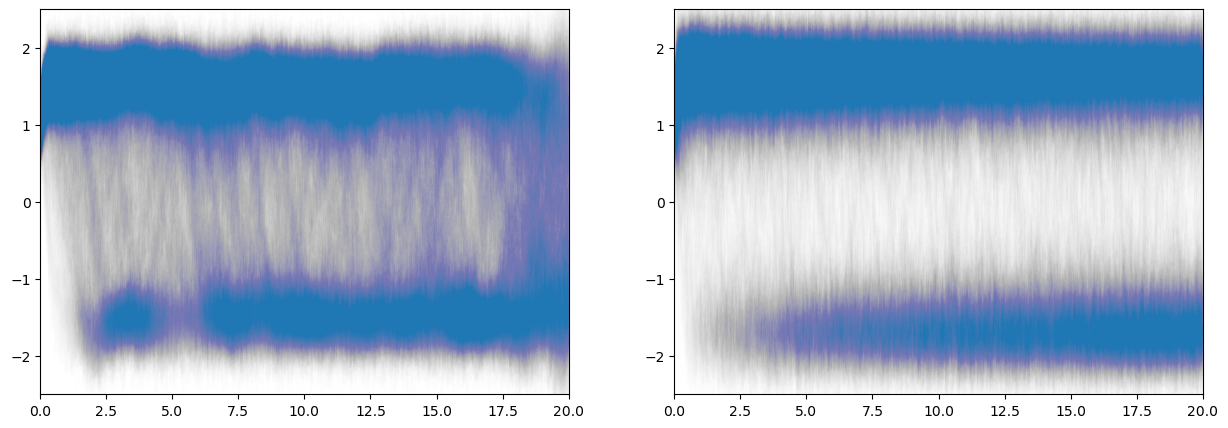

In [38]:
for a_val, c_val in zip([4, 2], [1, 3]):
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # PriorCVAE samples
    key = jax.random.PRNGKey(random.randint(0, 9999))
    a = a_val * jnp.ones((n, 1))
    c1 = c_val * jnp.ones((n, 1))
    c = jnp.concatenate([a, c1], axis=-1)
    cvae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)
    
    rng, _ = jax.random.split(key, 2)
    out_log_S = jnp.log(.05 * jnp.ones_like(cvae_samples))
    out_std = jnp.exp(0.5 * out_log_S)
    eps = jax.random.normal(rng, out_std.shape)
    cvae_samples = cvae_samples + eps * out_std
    

    for s in cvae_samples[:1000]:
        axs[0].plot(x, s, c="tab:blue", alpha=0.003)

    axs[0].set_xlim([x[0], x[-1]])
    axs[0].set_ylim([-2.5, 2.5])
    axs[0].set_title(f"PriorCVAE a={a_val}, c={c_val}")
    
    # DP Samples
    sde_datagenerator.base_sde.a = a_val
    sde_datagenerator.base_sde.c = c_val
    _, sde_vals, _ = sde_datagenerator.simulatedata(n_samples=n, sample_dp_params=False)

    for s in sde_vals[:1000]:
        axs[1].plot(x, s, c="tab:blue", alpha=0.003)

    axs[1].set_xlim([x[0], x[-1]])
    axs[1].set_ylim([-2.5, 2.5])
    axs[1].set_title(f"PriorCVAE a={a_val}, c={c_val}")

    plt.show()


## Plot the histogram

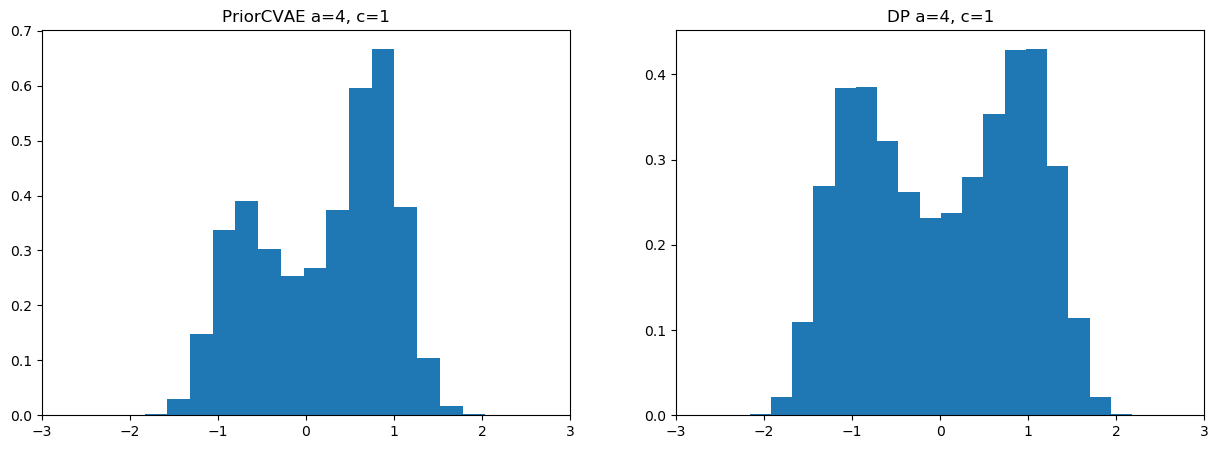

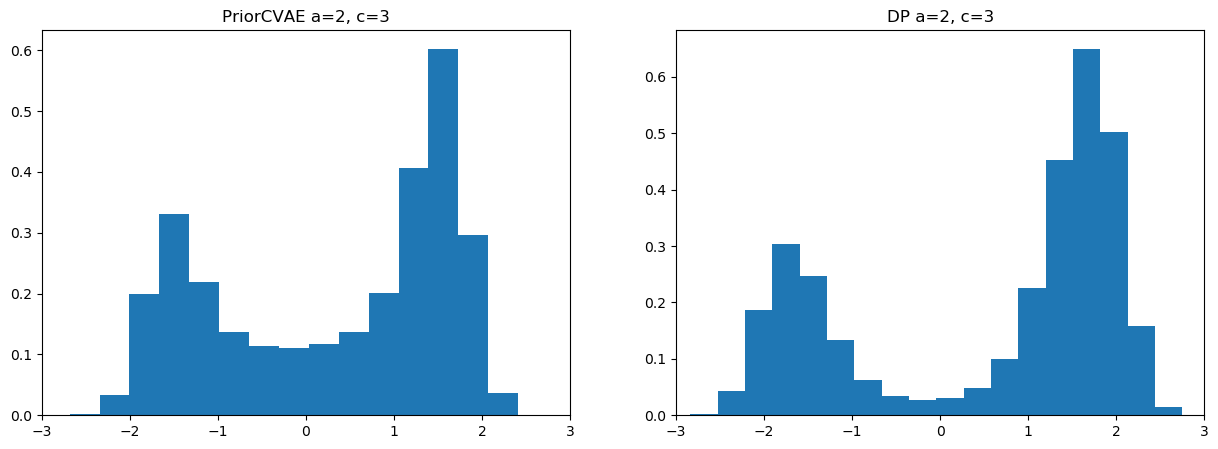

In [42]:
for a_val, c_val in zip([4, 2], [1, 3]):
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # PriorCVAE samples
    key = jax.random.PRNGKey(random.randint(0, 9999))
    a = a_val * jnp.ones((n, 1))
    c1 = c_val * jnp.ones((n, 1))
    c = jnp.concatenate([a, c1], axis=-1)
    cvae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)
    
    rng, _ = jax.random.split(key, 2)
    out_log_S = jnp.log(.05 * jnp.ones_like(cvae_samples))
    out_std = jnp.exp(0.5 * out_log_S)
    eps = jax.random.normal(rng, out_std.shape)
    cvae_samples = cvae_samples + eps * out_std
    
    axs[0].hist(cvae_samples.reshape(-1), bins=20, density=True)
    axs[0].set_xlim([-3, 3])
    axs[0].set_title(f"PriorCVAE a={a_val}, c={c_val}")
    
    # DP Samples
    sde_datagenerator.base_sde.a = a_val
    sde_datagenerator.base_sde.c = c_val
    _, sde_vals, _ = sde_datagenerator.simulatedata(n_samples=n, sample_dp_params=False)

    axs[1].hist(sde_vals.reshape(-1), bins=20, density=True)
    axs[1].set_xlim([-3, 3])
    axs[1].set_title(f"DP a={a_val}, c={c_val}")

    plt.show()   


## SAVE TEX

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

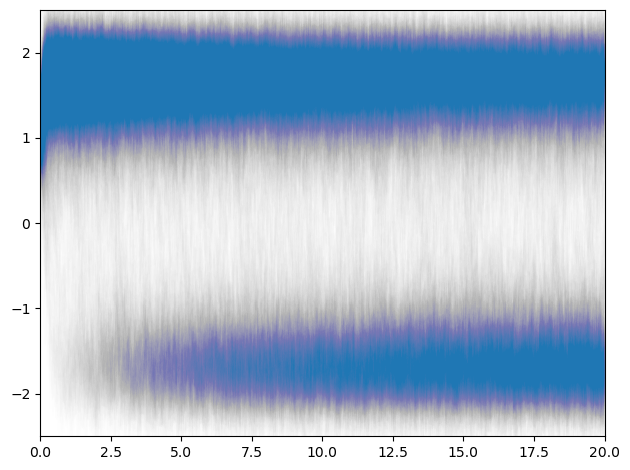

In [62]:
for a_val, c_val in zip([4, 2], [1, 3]):
    
    # PriorCVAE samples
    key = jax.random.PRNGKey(random.randint(0, 9999))
    a = a_val * jnp.ones((n, 1))
    c1 = c_val * jnp.ones((n, 1))
    c = jnp.concatenate([a, c1], axis=-1)
    cvae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)
    
    rng, _ = jax.random.split(key, 2)
    out_log_S = jnp.log(.05 * jnp.ones_like(cvae_samples))
    out_std = jnp.exp(0.5 * out_log_S)
    eps = jax.random.normal(rng, out_std.shape)
    cvae_samples = cvae_samples + eps * out_std
    
    plt.clf()
    fig, axs = plt.subplots(1, 1)
    for s in cvae_samples[:1000]:
        plt.plot(x, s, c="tab:blue", alpha=0.003)
    
    plt.xlim([x[0], x[-1]])
    plt.ylim([-2.5, 2.5])
    plt.tight_layout()
#     plt.set_title(f"PriorCVAE a={a_val}, c={c_val}")
    
    output_filename = f"DW_PriorCVAE_{a_val}_{c_val}_samps"
    output_file_path = os.path.join(output_dir, output_filename)
#     plt.savefig(output_file_path)
    bitmappify(axs)
    tikzplotlib.save(output_file_path,
                     figurewidth='\\figurewidth', figureheight='\\figureheight',
                     tex_relative_path_to_data='fig/',
                     figure=fig)
    
    
    # DP Samples
    sde_datagenerator.base_sde.a = a_val
    sde_datagenerator.base_sde.c = c_val
    _, sde_vals, _ = sde_datagenerator.simulatedata(n_samples=n, sample_dp_params=False)
        
    plt.clf()
    fig, axs = plt.subplots(1, 1)
    for s in sde_vals[:1000]:
        plt.plot(x, s, c="tab:blue", alpha=0.003)

    plt.xlim([x[0], x[-1]])
    plt.ylim([-2.5, 2.5])
    plt.tight_layout()
#     plt.set_title(f"PriorCVAE a={a_val}, c={c_val}")
    
    output_filename = f"DW_DP_{a_val}_{c_val}_samps"
    output_file_path = os.path.join(output_dir, output_filename)
    bitmappify(axs)
    tikzplotlib.save(output_file_path,
                     figurewidth='\\figurewidth', figureheight='\\figureheight',
                     tex_relative_path_to_data='fig/',
                     figure=fig)


<Figure size 640x480 with 0 Axes>

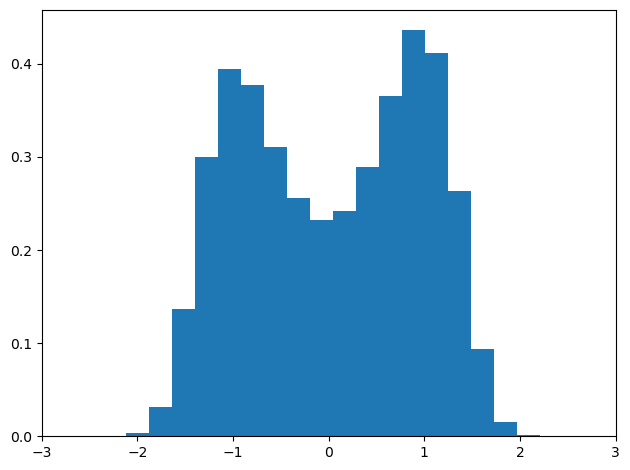

<Figure size 640x480 with 0 Axes>

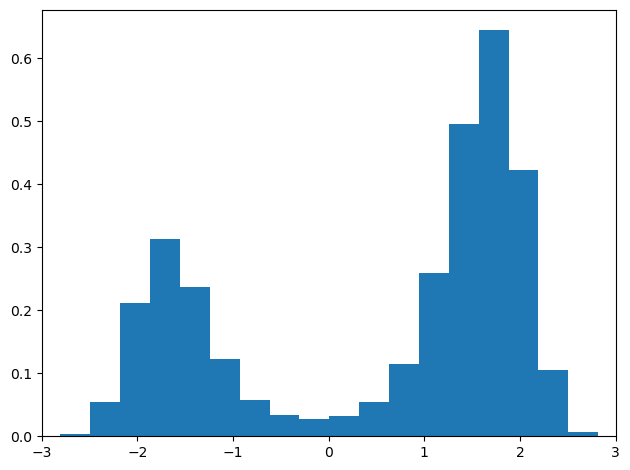

In [63]:
for a_val, c_val in zip([4, 2], [1, 3]):
    
    fig, axs = plt.subplots(1, 1)
    # PriorCVAE samples
    key = jax.random.PRNGKey(random.randint(0, 9999))
    a = a_val * jnp.ones((n, 1))
    c1 = c_val * jnp.ones((n, 1))
    c = jnp.concatenate([a, c1], axis=-1)
    cvae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)
    
    rng, _ = jax.random.split(key, 2)
    out_log_S = jnp.log(.05 * jnp.ones_like(cvae_samples))
    out_std = jnp.exp(0.5 * out_log_S)
    eps = jax.random.normal(rng, out_std.shape)
    cvae_samples = cvae_samples + eps * out_std
    
    plt.clf()    
    plt.hist(cvae_samples.reshape(-1), bins=20, density=True)
    plt.xlim([-3, 3])
    plt.tight_layout()
    output_filename = f"DW_PriorCVAE_{a_val}_{c_val}.tex"
    output_file_path = os.path.join(output_dir, output_filename)
    tikzplotlib.save(output_file_path,
                     figurewidth='\\figurewidth', figureheight='\\figureheight',
                     tex_relative_path_to_data='fig/',
                     figure=fig)
        
    # DP Samples
    sde_datagenerator.base_sde.a = a_val
    sde_datagenerator.base_sde.c = c_val
    _, sde_vals, _ = sde_datagenerator.simulatedata(n_samples=n, sample_dp_params=False)
        
    plt.clf()
    fig, axs = plt.subplots(1, 1)
    plt.hist(sde_vals.reshape(-1), bins=20, density=True)

    plt.xlim([-3, 3])
    plt.tight_layout()
    output_filename = f"DW_DP_{a_val}_{c_val}.tex"
    output_file_path = os.path.join(output_dir, output_filename)
    tikzplotlib.save(output_file_path,
                     figurewidth='\\figurewidth', figureheight='\\figureheight',
                     tex_relative_path_to_data='fig/',
                     figure=fig)
